In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_csv('/Users/egorskrobotov/Downloads/flights.csv', dtype=str)
df = df.loc[~df[['DEPARTURE_TIME', 'ARRIVAL_TIME']].isna().any(axis=1)]
df = df.loc[(df.ORIGIN_AIRPORT.apply(len) == 3) & (df.DESTINATION_AIRPORT.apply(len) == 3)]

df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].astype(float)
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].astype(float)
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

In [ ]:
Анализ распределения задержек вылета

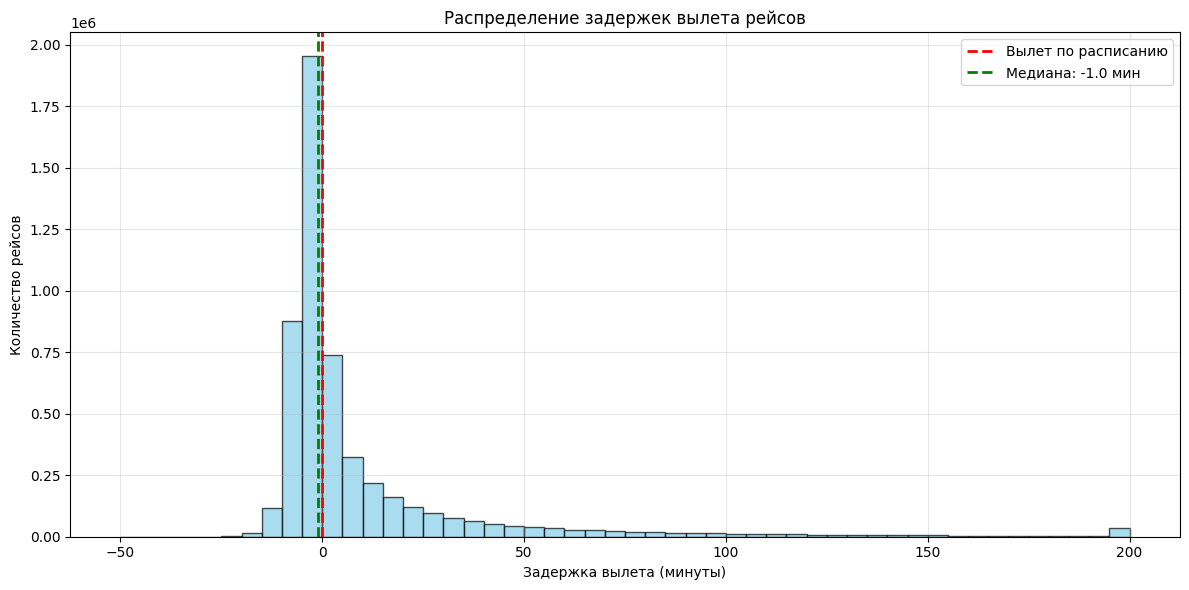

СТАТИСТИКА ЗАДЕРЖЕК ВЫЛЕТА:
Средняя задержка: 9.7 минут
Медианная задержка: -1.0 минут
Стандартное отклонение: 37.4 минут
Доля рейсов с задержкой > 15 мин: 18.3%
Доля рейсов с задержкой > 60 мин: 5.8%
Доля рейсов, вылетевших раньше расписания: 56.6%


In [17]:
plt.figure(figsize=(12, 6))

plt.hist(df['DEPARTURE_DELAY'].clip(-50, 200), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Задержка вылета (минуты)')
plt.ylabel('Количество рейсов')
plt.title('Распределение задержек вылета рейсов')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Вылет по расписанию')
plt.axvline(x=df['DEPARTURE_DELAY'].median(), color='green', linestyle='--', linewidth=2, label=f'Медиана: {df["DEPARTURE_DELAY"].median():.1f} мин')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("СТАТИСТИКА ЗАДЕРЖЕК ВЫЛЕТА:")
print(f"Средняя задержка: {df['DEPARTURE_DELAY'].mean():.1f} минут")
print(f"Медианная задержка: {df['DEPARTURE_DELAY'].median():.1f} минут")
print(f"Стандартное отклонение: {df['DEPARTURE_DELAY'].std():.1f} минут")
print(f"Доля рейсов с задержкой > 15 мин: {(df['DEPARTURE_DELAY'] > 15).mean()*100:.1f}%")
print(f"Доля рейсов с задержкой > 60 мин: {(df['DEPARTURE_DELAY'] > 60).mean()*100:.1f}%")
print(f"Доля рейсов, вылетевших раньше расписания: {(df['DEPARTURE_DELAY'] < 0).mean()*100:.1f}%")

In [ ]:
Вывод: Большинство рейсов вылетают с незначительными задержками или раньше расписания,
однако существует значительный хвост распределения - некоторые рейсы задерживаются на несколько часов.

In [ ]:
Анализ задержек от времени суток

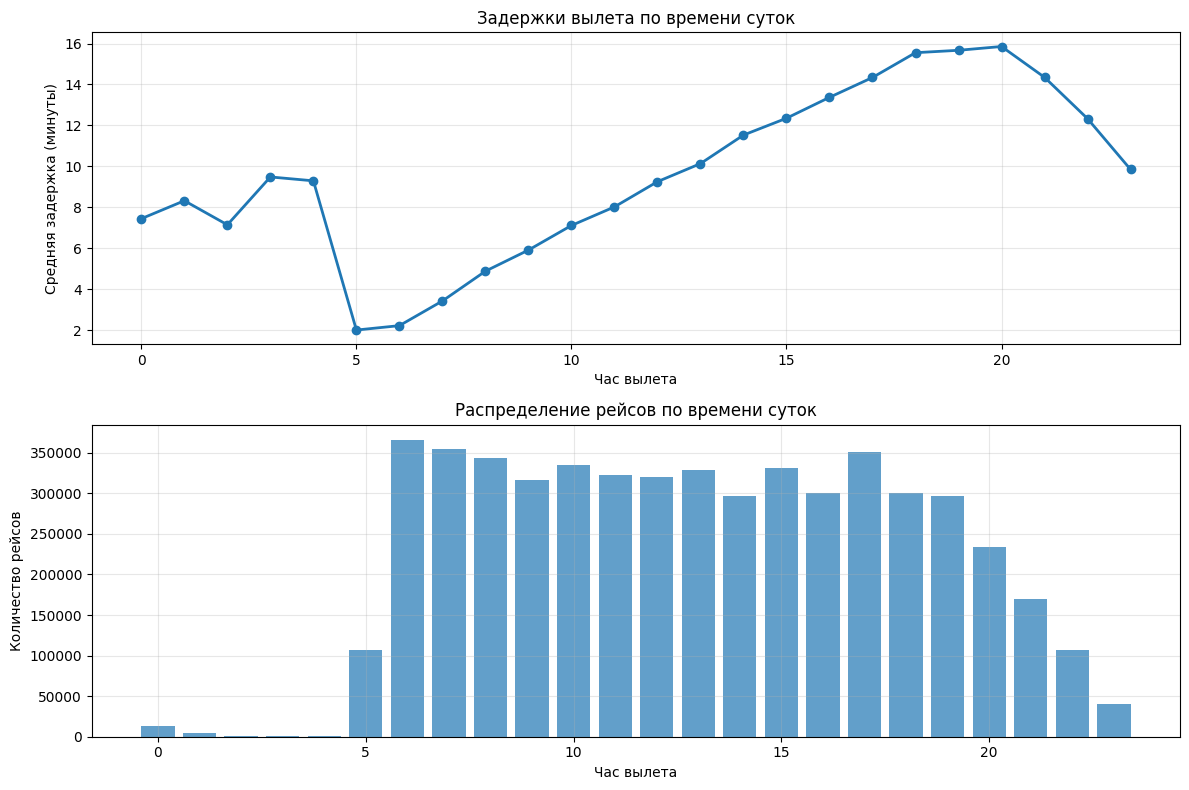

In [28]:
# Преобразование времени вылета
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].str.zfill(4)
df['DEPARTURE_HOUR'] = df['SCHEDULED_DEPARTURE'].str[:2].astype(int)

hourly_delays = df.groupby('DEPARTURE_HOUR')['DEPARTURE_DELAY'].agg(['mean', 'count']).reset_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Задержки по часам
ax1.plot(hourly_delays['DEPARTURE_HOUR'], hourly_delays['mean'], marker='o', linewidth=2)
ax1.set_xlabel('Час вылета')
ax1.set_ylabel('Средняя задержка (минуты)')
ax1.set_title('Задержки вылета по времени суток')
ax1.grid(True, alpha=0.3)

# Количество рейсов по часам
ax2.bar(hourly_delays['DEPARTURE_HOUR'], hourly_delays['count'], alpha=0.7)
ax2.set_xlabel('Час вылета')
ax2.set_ylabel('Количество рейсов')
ax2.set_title('Распределение рейсов по времени суток')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
Вывод: утренние рейсы (начиная с 5 часов) наиболее пунктуальны, тогда как вечерние рейсы накапливают задержки в течение дня.

In [ ]:
Анализ задержек по типам самолетов

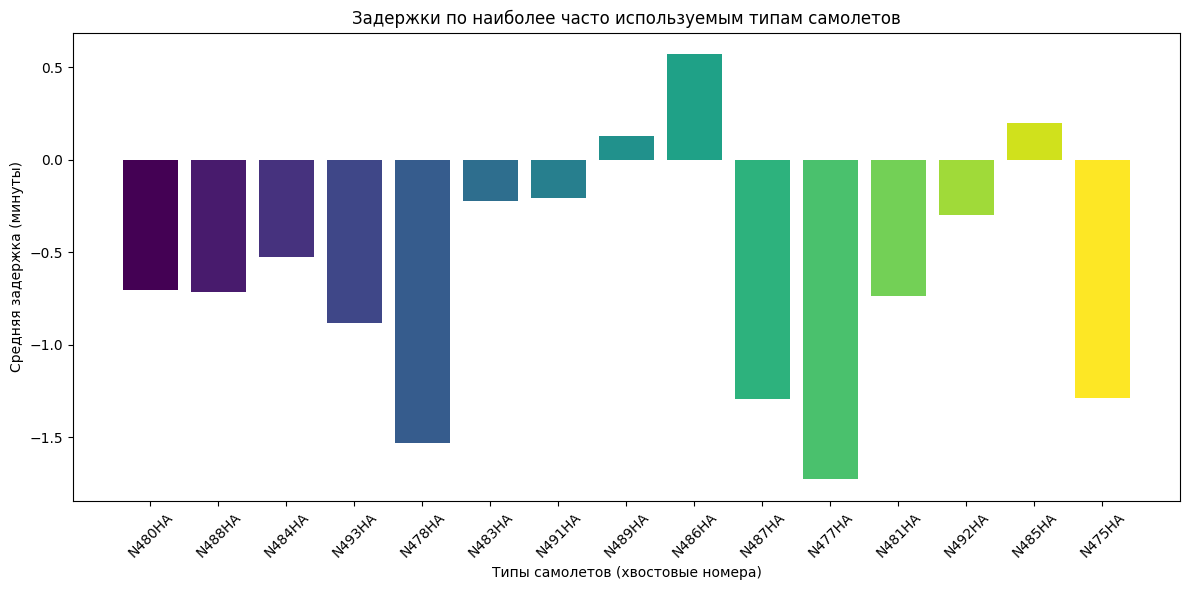

In [35]:
tail_number_delays = df.groupby('TAIL_NUMBER')['DEPARTURE_DELAY'].agg(['mean', 'count']).reset_index()
#уберем непопулярные
frequent_aircraft = tail_number_delays[tail_number_delays['count'] > 1000].nlargest(15, 'count')

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(frequent_aircraft)), frequent_aircraft['mean'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(frequent_aircraft))))
plt.xlabel('Типы самолетов (хвостовые номера)')
plt.ylabel('Средняя задержка (минуты)')
plt.title('Задержки по наиболее часто используемым типам самолетов')
plt.xticks(range(len(frequent_aircraft)), frequent_aircraft['TAIL_NUMBER'], rotation=45)


plt.tight_layout()
plt.show()

In [ ]:
Вывод: Некоторые конкретные самолеты показывают систематически высокие задержки, что может указывать на их сложности эксплуатации

In [ ]:
Корелляция между популярностью аэропорта и отношением количества аэропортов с меньшим средним ко всему количеству

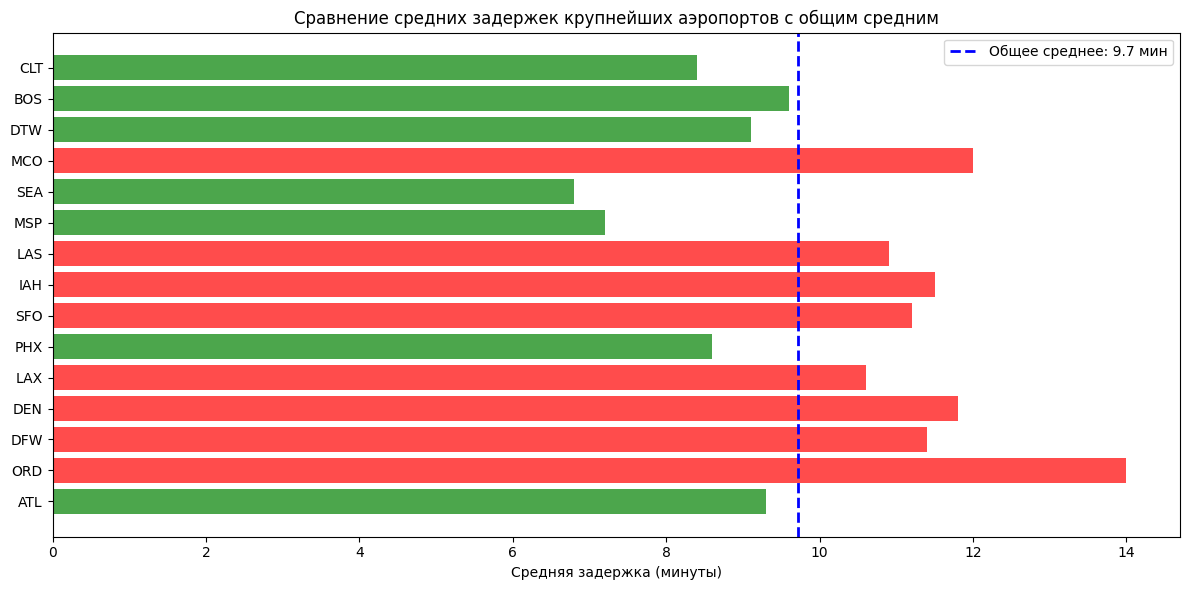

Аэропортов лучше среднего по задержкам: 7 из 15


In [18]:
top_airports = df['ORIGIN_AIRPORT'].value_counts().head(15)
airport_delays = df.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].agg(['mean', 'median', 'count']).round(1)
top_airport_delays = airport_delays.loc[top_airports.index]
overall_mean_delay = df['DEPARTURE_DELAY'].mean()


plt.figure(figsize=(12, 6))
bars = plt.barh(top_airport_delays.index, top_airport_delays['mean'], 
                color=['red' if x > overall_mean_delay else 'green' for x in top_airport_delays['mean']],
                alpha=0.7)
plt.axvline(x=overall_mean_delay, color='blue', linestyle='--', linewidth=2, 
            label=f'Общее среднее: {overall_mean_delay:.1f} мин')
plt.xlabel('Средняя задержка (минуты)')
plt.title('Сравнение средних задержек крупнейших аэропортов с общим средним')
plt.legend()
plt.tight_layout()
plt.show()


better_than_avg = (top_airport_delays['mean'] < overall_mean_delay).sum()
print(f"Аэропортов лучше среднего по задержкам: {better_than_avg} из {len(top_airport_delays)}")

In [ ]:
Вывод: отношение аэропортов с меньшим средним ко всему количеству не зависит от их популярности, т.к. 7≈1/2 

In [ ]:
Корелляция между задержками расстоянием

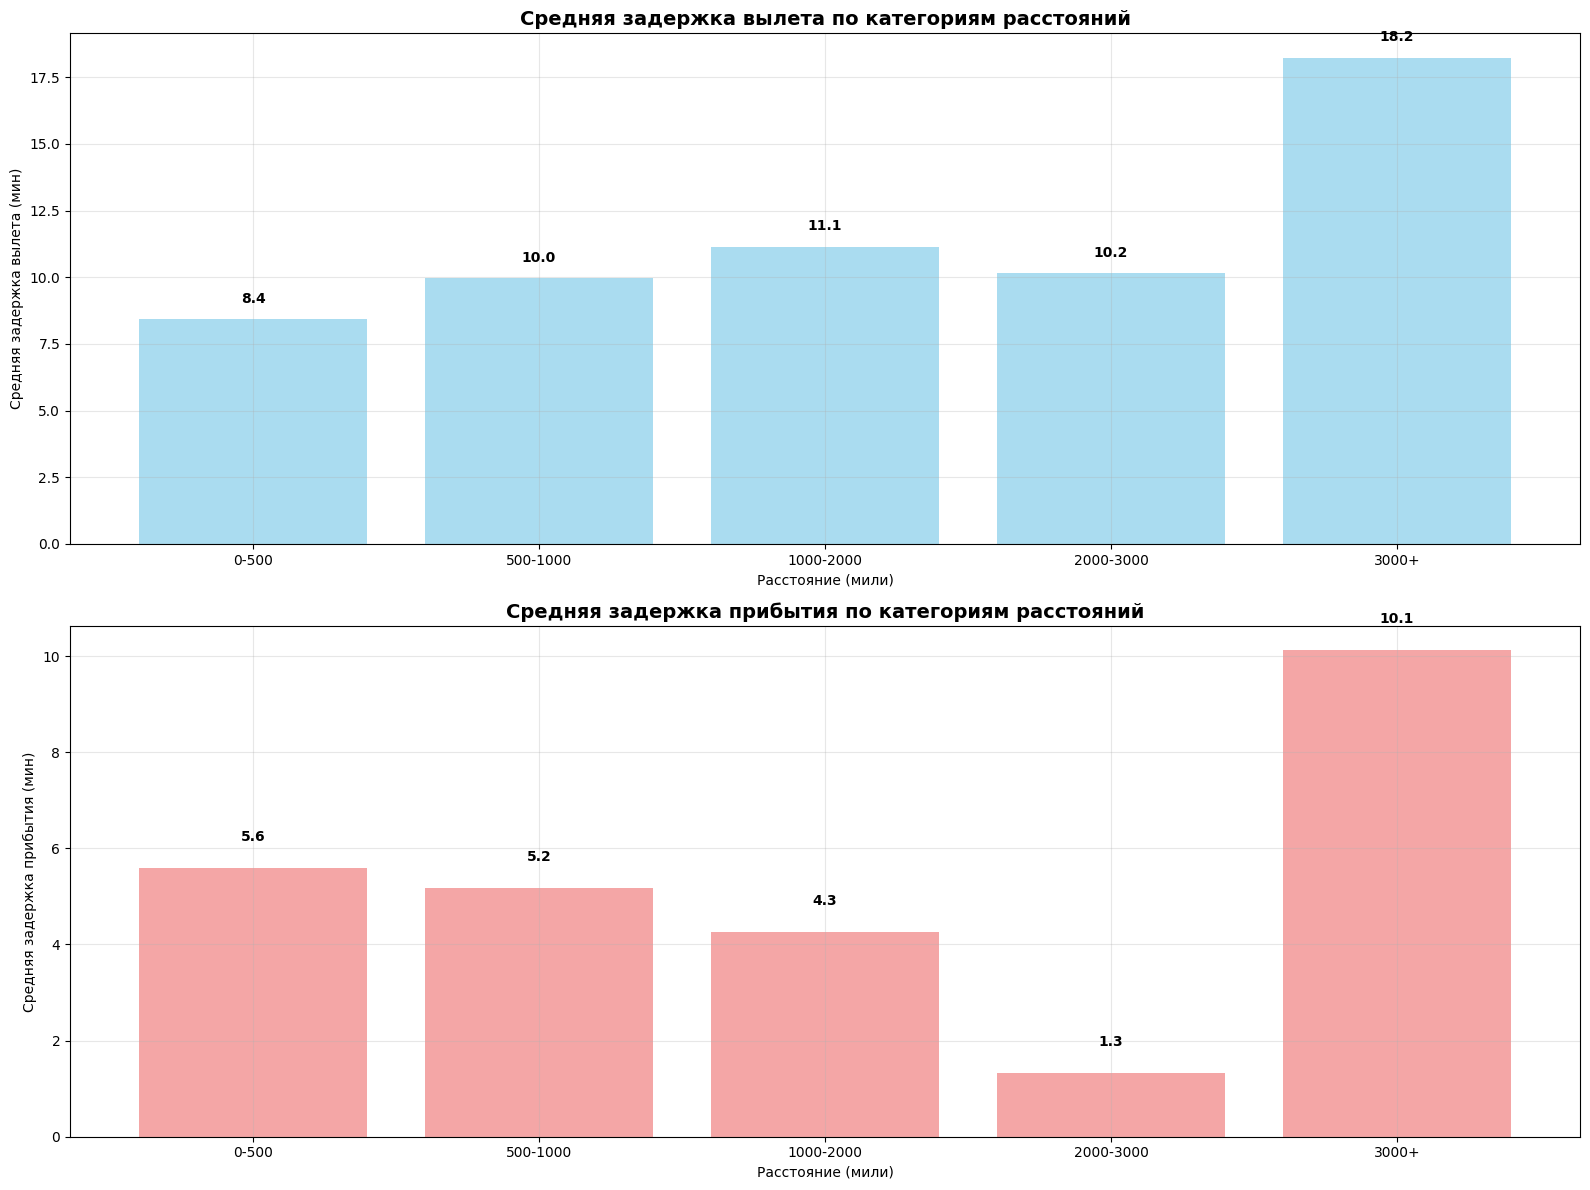

In [29]:
df['DISTANCE'] = pd.to_numeric(df['DISTANCE'], errors='coerce')
analysis_df = df[['DISTANCE', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']].dropna()
analysis_df['DISTANCE_CAT'] = pd.cut(analysis_df['DISTANCE'], 
                                    bins=[0, 500, 1000, 2000, 3000, float('inf')],
                                    labels=['0-500', '500-1000', '1000-2000', '2000-3000', '3000+'])

delay_stats = analysis_df.groupby('DISTANCE_CAT', observed=False).agg({
    'DEPARTURE_DELAY': ['mean', 'median', 'std', 'count'],
    'ARRIVAL_DELAY': ['mean', 'median', 'std']
}).round(2)

analysis_df['DELAY_DIFF'] = analysis_df['ARRIVAL_DELAY'] - analysis_df['DEPARTURE_DELAY']

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

# График 1: Средняя задержка вылета по расстоянию
distance_groups = analysis_df.groupby('DISTANCE_CAT', observed=False)['DEPARTURE_DELAY'].mean()
ax1.bar(distance_groups.index, distance_groups.values, color='skyblue', alpha=0.7)
ax1.set_title('Средняя задержка вылета по категориям расстояний', fontsize=14, fontweight='bold')
ax1.set_xlabel('Расстояние (мили)')
ax1.set_ylabel('Средняя задержка вылета (мин)')
ax1.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(distance_groups.values):
    ax1.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# График 2: Средняя задержка прибытия по расстоянию
arrival_groups = analysis_df.groupby('DISTANCE_CAT', observed=False)['ARRIVAL_DELAY'].mean()
ax2.bar(arrival_groups.index, arrival_groups.values, color='lightcoral', alpha=0.7)
ax2.set_title('Средняя задержка прибытия по категориям расстояний', fontsize=14, fontweight='bold')
ax2.set_xlabel('Расстояние (мили)')
ax2.set_ylabel('Средняя задержка прибытия (мин)')
ax2.grid(True, alpha=0.3)

for i, v in enumerate(arrival_groups.values):
    ax2.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')



plt.tight_layout()
plt.show()


In [31]:
Вывод: на очень коротких/длинных маршрутах задержка вылета в среднем меньше/больше по отношению к другим, в остальных в среднем одиннаково
Задержка прибытия в среднем уменьшается по сравнению с отбытием (видимо самолет пытается подогнать время под нужное).
До 3000 миль чем больше расстояние тем меньше задержка прибытия, после 3000 происходит скачок 

SyntaxError: invalid syntax (2109280465.py, line 1)